# Using `BigInteger` to compile Shor's algorithm at 2048 bit

In the [Jasp tutorial](Jasp.ipynb), we learned how Jasp allows us to use Qrisp to compile quantum algorithms at utility-scale.
However, Jasp has a caveat that may not be immediately apparent to those coming from Python: it uses fixed-size integers.
On the other hand, Python's `int` supports arbitrary sizes.
For example, let us create a large integer, parse it to Jasp, and return it to Python:

In [18]:
from qrisp import *

a = 2**64

@jaspify
def return_integer(i):
    return i

try:
    b = return_integer(a)
except OverflowError as e:
    print(e)

An overflow was encountered while parsing an argument to a jitted computation, whose argument path is args[0].


Here, Jasp checks the integer for its size before parsing it to the jitted computation and raises an error.
However, not all internal computations are bounds-checked.

In [19]:
from qrisp import *

a = 2**40

@jaspify
def add_to_integer(i):
    return i*2**40

r_jasp = add_to_integer(a)
r_python = a * 2**40
print("Python:", r_python)
print("Jasp:", r_jasp)

Python: 1208925819614629174706176
Jasp: 0


Here, we perform the same computation using Python and Jasp and get different results.
Additionally, we are not alerted to the problem since Jasp does not check bound violations on all internal computations.

This issue is known as _Integer overflow_ and is a common pitfall in many programming languages and libraries with fixed-size integer types, such as numpy and jax.numpy.
It is a direct consequence of setting the size of the integer to a static value, for example, 32- or 64-bit, and many other basic data types are handled the same way.
Doing this allows for well-optimized operations and avoids additional overhead introduced by managing a dynamically-sized data container.
In fact, we are not able to circumvent this restriction in general because of the limitations of Jasp.
Still, to allow us to work with integers that are larger than the native 32- or 64-bit types, we provide the [BigInteger](../../reference/Jasp/Scalable%20Integer%20Type.rst) class.

The idea of the `BigInteger` class is easily explained: represent very large integers that do not fit into the default sizes.
Internally, the `BigInteger` uses an array of 32-bit integers to represent larger values.
As required by Jasp, this array possesses a static size.
Now, we will see how to work with this integer.

## Working classically with `BigInteger`

To create an instance of the `BigInteger` class, we can make use of the `create_static` or `create_dynamic` function.
Where `create_static` can be used with Jasp, but the value argument must be a static Python integer, the function `create_dynamic` is written in terms of Jax primitives.
This distinction showcases a key problem when working at the intersection of Python and Jasp.
We cannot exactly create a BigInteger that is too large for the native Jax types when using `create_dynamic` as the used Jax functions require a size-limited integer.
In these cases, we must use `create_static`.
For example, let us create a 2048-bit integer.

In [20]:
@jaspify
def create_bi():
    return BigInteger.create_dynamic(123456, 64) # Works because 123456 fits into 64 bits

bi_small = create_bi()
bi_large = BigInteger.create_static(2**1200, 64) # Works because we use the static function

For both functions, the first argument is the value of the integer and the second is the number of 32-bit digits (limbs) to allocate for the instance.
Here, we choose 64 since $64\cdot 32 = 2048$.
To obtain the value stored in the integer, we use the `__call__` method, which can be called by opening and closing brackets `()`.

In [21]:
print("bi_large:", bi_large())
print("Correct value:", bi_large() == 2**1200)

bi_large: 17218479456385750618067377696052635483579924745448689921733236816400740691241745619397484537236046173286370919031961587788584927290816661024991609882728717344659503471655990880884679896520055123906467064419056526231345685268240569209892573766037966584735183775739433978714578587782701380797240772477647874555986712746271362892227516205318914435913511141036261376
Correct value: True


In Python-mode, that is, outside any Jasp function, the method returns a Python integer of the value stored inside the `BigInteger` instance.
However, when using this method in Jasp-mode this is not possible, and thus the method returns an approximation of the value as a 64-bit float.

The `BigInteger` class supports a wide range of operators to perform basic arithmetic operations, comparisons, and bit operations

In [22]:
@jaspify
def add_bi(a, b): return a + b
@jaspify
def sub_bi(a, b): return a - b
@jaspify
def mul_bi(a, b): return a * b
@jaspify
def div_bi(a, b): return a // b
@jaspify
def mod_bi(a, b): return a % b
@jaspify
def pow_bi(a, b): return a ** b
@jaspify
def ge_bi(a, b): return a >= b
@jaspify
def lt_bi(a, b): return a < b
@jaspify
def eq_bi(a, b): return a == b
@jaspify
def lshift_bi(a, b): return a << b
@jaspify
def xor_bi(a, b): return a ^ b

x = BigInteger.create_static(2**1200, 64)
y = BigInteger.create_static(3**600, 64)

print("x+y :", add_bi(x, y)())
print("x-y :", sub_bi(x, y)())
print("x*y :", mul_bi(x, y)())
print("x//y :", div_bi(x, y)())
print("x%y :", mod_bi(x, y)())
print("y**2 :", pow_bi(y, 2)())
print("x>=y :", ge_bi(x, y))
print("x<y :", lt_bi(x, y))
print("x==y :", eq_bi(x, y))
print("x<<2 :", lshift_bi(x, 2)())
print("x^y :", xor_bi(x, y)())

x+y : 17218479456385750618067377696052635483579924745448689921733236816400740691260484896436332477122800193206729042456270056819577708848783571008203520845886481023385623626125021737692410484491915034285536152112175577316485251485611204293277517379905996129992080893738042135558278052875995146630382082004344231698587579681960846663105331219780109273605735020941393377
x-y : 17218479456385750618067377696052635483579924745448689921733236816400740691223006342358636597349292153366012795607653118757592145732849751041779698919570953665933383317186960024076949308548195213527397976725937475146206119050869934126507630152169937039478286657740825821870879122689407614964099462950951517413385845810581879121349701190857719598221287261131129375
x*y : 8363043341027444121468938611480630920438942712615916971099048250985091232155340228727201791705502299888383881875681387012270433277369258018508202481320213865942876403283694718548430325199563774324634664985322015097449368736012632707454793872836804979502966

Here, we use functions with the `@jaspify` annotation to showcase that the `BigInteger` works in Jasp mode.
For a complete list, see the documentation of the [BigInteger](../../reference/Jasp/Scalable%20Integer%20Type.rst).

## Finding the order of a `BigInteger`

As we learned in the [Shor tutorial](Shor.ipynb), the problem of factoring can be reduced to order-finding.
Shor's algorithm does exactly that and provides an efficient quantum algorithm for order-finding.
Following the [fault-tolerant compilation tutorial](FT_compilation.ipynb), we implement this

In [23]:
def find_order(a: BigInteger, N: BigInteger):
    qg = QuantumModulus(N, inpl_adder=gidney_adder)
    qg[:] = 1
    qpe_res = QuantumFloat(2*qg.size + 1)
    h(qpe_res)
    for i in jrange(qpe_res.size):
        with control(qpe_res[i]):
            qg *= a
        a = (a*a)%N
    QFT(qpe_res, inv = True)
    return measure_to_big_integer(qpe_res, a.digits.size)

The function `find_order` provides a Jasp-compatible implementation of order-finding that makes use of the BigInteger class.
Note that we use the function `measure_to_big_integer` instead of `measure` to return the measured value of the quantum variable as a big integer.
This use case shows the importance of the `BigInteger` class, since a native Jax integer is limited to 64 bits.
Only minimal modifications are required to make the implementation compatible with the new integer type.

Of course, we cannot run this function for, say, 2048-bit integers on a classical computer.
Still, we are able to perform resource estimation using this implementation.
Here, we run resource estimation of 128-bit integers.

In [24]:
@count_ops(meas_behavior="0")
def find_order_count_ops(a: BigInteger, N: BigInteger):
    qg = QuantumModulus(N, inpl_adder=gidney_adder)
    qg[:] = 1
    qpe_res = QuantumFloat(2*qg.size + 1)
    h(qpe_res)
    for i in jrange(qpe_res.size):
        with control(qpe_res[i]):
            qg *= a
        a = (a*a)%N
    QFT(qpe_res, inv = True)
    return measure_to_big_integer(qpe_res, a.digits.size)

N = BigInteger.create_static(151557408999110657826917604970069258585, size=10)
a = BigInteger.create_static(10409234017673608357083055217615539999, size=10)
    
ops_count = find_order_count_ops(a, N)
print(ops_count)

{'s': 36607456, 'h': 110017188, 'cx': 386608045, 't': 73506377, 't_dg': 73603532, 'p': 97155, 'x': 1021, 'measure': 36607711}


## Parallel resource estimation at 2048 bit

The above approach works well for moderate bit sizes.
However, for very large instances - such as 2048-bit integers - the sequential execution of the full QPE loop becomes prohibitively slow - even with the highly optimized XLA pipeline.
To overcome this, we can decompose the resource estimation into independent chunks and evaluate them in parallel.

The key insight is that the QPE control register can be split into non-overlapping *windows*.
Each window covers a contiguous range of loop indices and generates an independent set of quantum gates.
Since we are only counting operations (not simulating a quantum state), the gate counts from all windows can simply be summed.

### How the parallelization works

1. **Domain decomposition**: The control register of size $2n$ is divided into `num_threads` chunks of roughly equal size.
2. **Parallel tracing**: Each chunk is assigned to a separate thread. Inside each thread, the full loop is iterated (to keep the classical squaring sequence $a \leftarrow a^2 \bmod N$ consistent), but quantum gates are only emitted for indices within the thread's assigned window.
3. **GIL release**: Qrisp's `count_ops` uses `jax.jit` internally. JAX releases the Python Global Interpreter Lock (GIL) during compilation and execution, so the threads run in true parallel on the CPU.
4. **Aggregation**: The operation dictionaries from all threads are summed to produce the total gate count.

We wrap this into a reusable function `estimate_shor_resources` that takes a bit size and returns the operation counts.

In [25]:
import jax
import collections
import time
from concurrent.futures import ThreadPoolExecutor

def estimate_shor_resources(bit_amount, num_threads=16):
    """
    Estimate the quantum resource requirements of Shor's algorithm
    for a given bit size using parallelized windowed tracing.
    
    Parameters
    ----------
    bit_amount : int
        The bit size of the integers to factor.
    num_threads : int
        Number of parallel threads for the windowed decomposition.
    
    Returns
    -------
    dict
        Dictionary mapping gate names to their total counts.
    """
    
    # Generate random integers of the specified bit size
    a_str = "1" + "".join(str(np.random.randint(2)) for _ in range(bit_amount - 1))
    N_str = "1" + "".join(str(np.random.randint(2)) for _ in range(bit_amount - 1))
    
    a_python = int(a_str, 2)
    N_python = int(N_str, 2)
    
    # Ensure a < N
    if a_python > N_python:
        a_python = a_python // 2

    @count_ops(meas_behavior="1")
    def shor_ops_kernel(window_start, window_end, execute_qft):
        """
        Trace a partial circuit for Shor's algorithm covering a specific 
        window of QPE control indices.
        """
        N = BigInteger.create_static(N_python, size=bit_amount // 32)
        a = BigInteger.create_static(a_python, size=bit_amount // 32)
        
        qm = QuantumModulus(N)
        qpe_res = QuantumFloat(2 * bit_amount)
        
        # Only the first chunk applies the initial Hadamards
        with control(window_start == 0):
            h(qpe_res)
        
        for i in jrange(qpe_res.size):
            active_window = (i >= window_start) & (i < window_end)
            with control(active_window):
                # Print progress every 10 iterations within the window

                # Activate this for progress feedback during the resource computation.
                if False:
                    with control(i % 10 == 0):
                        jax.debug.print(
                            "Thread [{s},{e}) progress: {p:.1%}",
                            s=window_start, e=window_end,
                            p=(i - window_start) / (window_end - window_start)
                        )
                with control(qpe_res[i]):
                    qm *= a
            a = (a * a) % N

        # The last thread adds the inverse QFT and measurement
        with control(execute_qft):
            QFT(qpe_res, inv=True)
            measure(qpe_res)

    # Warm up the JIT cache on the main thread to avoid race conditions
    shor_ops_kernel(0, 2, False)
    
    chunk_size = (2 * bit_amount) // num_threads
    futures = []
    ops_dict = collections.defaultdict(int)
    
    print(f"Estimating resources for {bit_amount}-bit Shor's algorithm "
          f"({num_threads} threads)...")
    t0 = time.time()
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        for i in range(num_threads):
            window_start = i * chunk_size
            window_end = (i + 1) * chunk_size if i != num_threads - 1 else 2 * bit_amount
            execute_qft = (i == num_threads - 1)
            futures.append(
                executor.submit(shor_ops_kernel, window_start, window_end, execute_qft)
            )
        
        for future in futures:
            result_dict = future.result()
            for k, v in result_dict.items():
                ops_dict[k] += v
    
    elapsed = time.time() - t0
    print(f"  Done in {elapsed:.1f}s — {dict(ops_dict)}")
    return dict(ops_dict)

We now call this function for increasing bit sizes. Note that the 2048-bit call may run for **several hours** depending on your hardware.

In [26]:
bit_sizes = [128, 256, 512]
all_resources = {}

for bit_size in bit_sizes:
    all_resources[bit_size] = estimate_shor_resources(bit_size)

Estimating resources for 128-bit Shor's algorithm (16 threads)...
  Done in 0.1s — {'s': 9790868, 'cz': 9790868, 'h': 29569724, 'cx': 92424031, 't': 19876648, 't_dg': 19974952, 'x': 9791892, 'measure': 9791124, 'p': 97920}
Estimating resources for 256-bit Shor's algorithm (16 threads)...
  Done in 1.0s — {'s': 95496774, 'cz': 95496774, 'h': 287277778, 'cx': 925776044, 't': 192173196, 't_dg': 192566412, 'x': 95498822, 'measure': 95497286, 'p': 392448}
Estimating resources for 512-bit Shor's algorithm (16 threads)...
  Done in 45.1s — {'s': 1552968630, 'cz': 1552968630, 'h': 4662053666, 'cx': 16162219356, 't': 3110655852, 't_dg': 3112228716, 'x': 1552972726, 'measure': 1552969654, 'p': 1571328}


We can now visualize how the gate counts scale with the bit size of the integers to be factored.

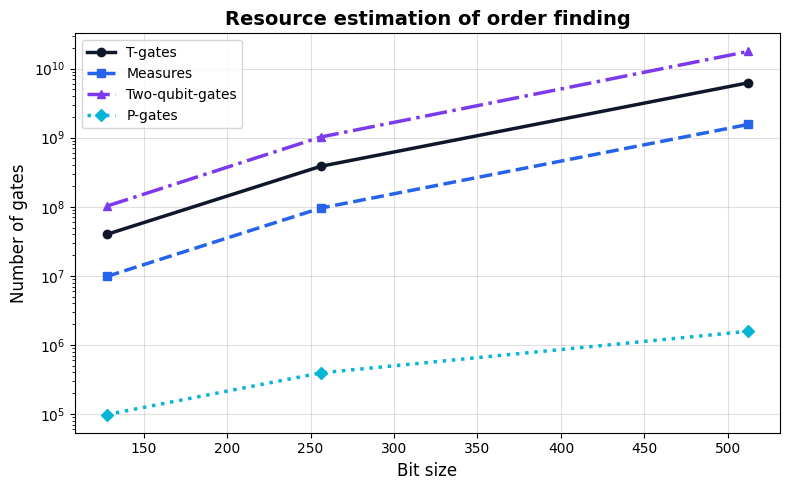

In [31]:
import matplotlib.pyplot as plt

style = {
    "T-gates":         {"color": "#0f172a", "marker": "o", "linestyle": "-"},
    "Measures":        {"color": "#2563eb", "marker": "s", "linestyle": "--"},
    "Two-qubit-gates": {"color": "#7c3aed", "marker": "^", "linestyle": "-."},
    "P-gates":         {"color": "#06b6d4", "marker": "D", "linestyle": ":"},
}

categories = {
    "T-gates":         lambda r: r.get("t", 0) + r.get("t_dg", 0),
    "Measures":        lambda r: r.get("measure", 0),
    "Two-qubit-gates": lambda r: r.get("cx", 0) + r.get("cz", 0),
    "P-gates":         lambda r: r.get("p", 0),
}

fig, ax = plt.subplots(figsize=(8, 5))

for label, extractor in categories.items():
    counts = {bs: extractor(res) for bs, res in all_resources.items()}
    s = style[label]
    ax.plot(list(counts.keys()), list(counts.values()),
            color=s["color"], marker=s["marker"], linestyle=s["linestyle"],
            linewidth=2.5, markersize=6, label=label)

ax.set_xlabel("Bit size", fontsize=12)
ax.set_ylabel("Number of gates", fontsize=12)
ax.set_title("Resource estimation of order finding", fontsize=14, fontweight="bold")
ax.set_yscale("log")
ax.legend(fontsize=10, loc="upper left")
ax.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()